In [2]:
%cd C:\Users\esurujiu\AppData\Local\miniconda3\envs\GOs

import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL  
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from sklearn.decomposition import PCA
import pywt
import calendar
from statsmodels.graphics.tsaplots import month_plot
import scipy.stats as st
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime
import statsmodels.formula.api as smf

C:\Users\esurujiu\AppData\Local\miniconda3\envs\GOs


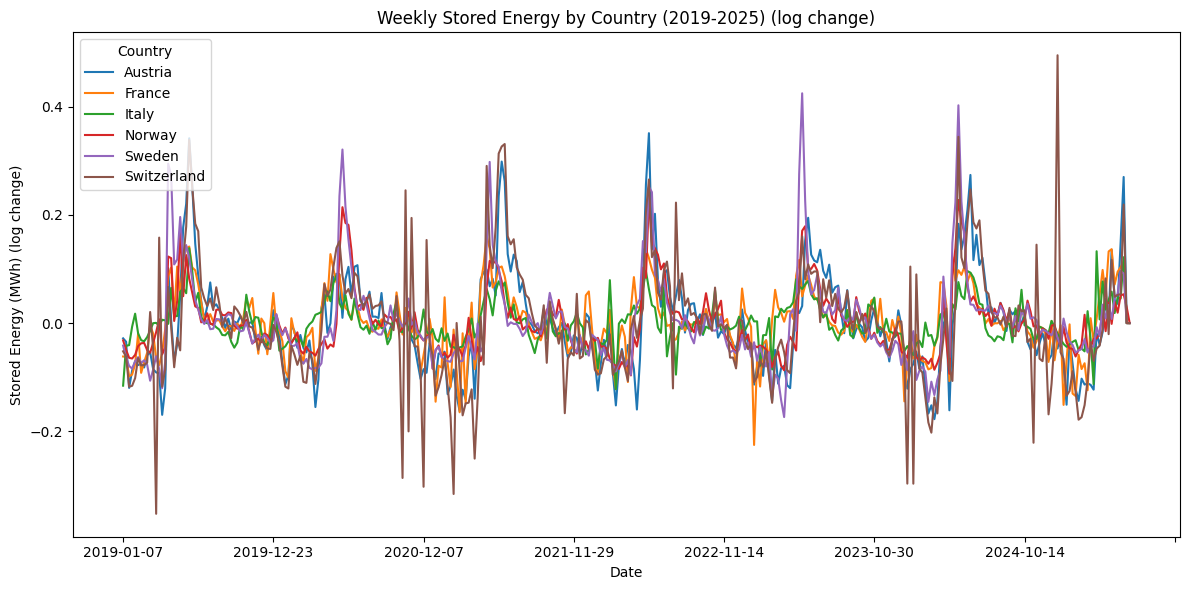

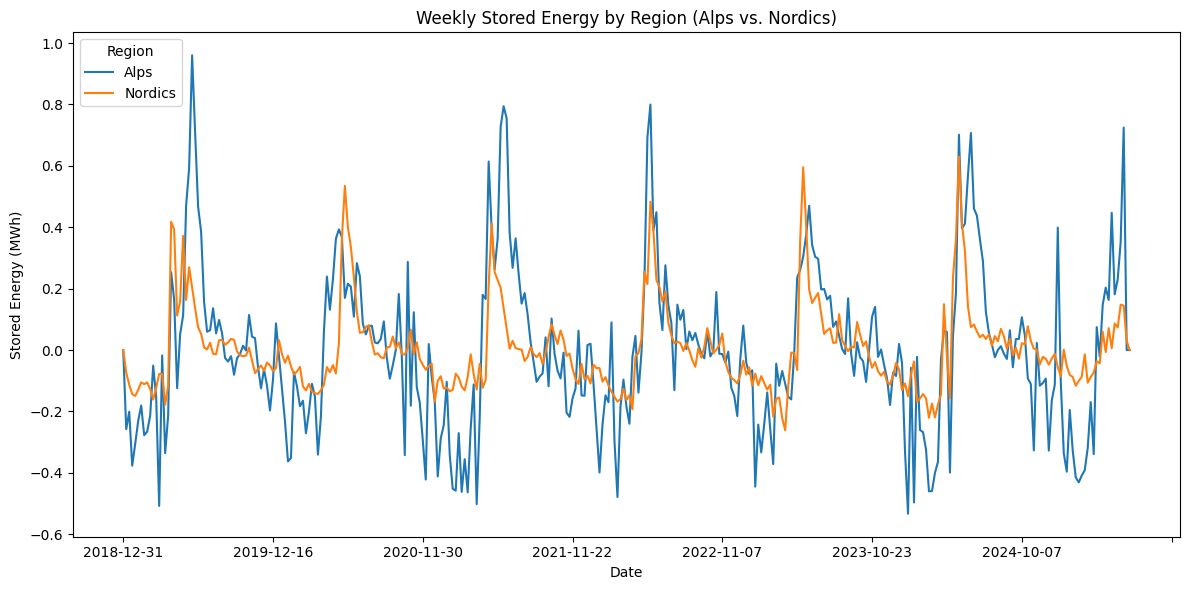

In [4]:
weekly = pd.read_csv('data/01_interim/GO_weekly_price_change.csv')
water = pd.read_csv('data/01_interim/hydro_storage.csv')

water['dStorage'] = water.groupby('Country')['StoredEnergy'].diff()

water['logStorage'] = np.log(water['StoredEnergy'])
water['dlogStorage'] = water.groupby('Country')['logStorage'].diff()

pivot_country = (
    water.pivot_table(
        index='Date',
        columns='Country',
        values='dlogStorage',
        aggfunc='mean'     # change to 'mean' if you prefer averages
    )
    .sort_index()
)
plt.figure(figsize=(12, 6))
pivot_country.plot(ax=plt.gca())
plt.title('Weekly Stored Energy by Country (2019-2025) (log change)')
plt.xlabel('Date')
plt.ylabel('Stored Energy (MWh) (log change)')
plt.legend(title='Country', loc='upper left')
plt.tight_layout()
plt.show()


# 5. -------- Plot 2: regional graph --------
pivot_region = (
    water.groupby(['Date', 'Region'])['dlogStorage']
    .sum()
    .unstack('Region')
    .sort_index()
)

plt.figure(figsize=(12, 6))
pivot_region.plot(ax=plt.gca())
plt.title('Weekly Stored Energy by Region (Alps vs. Nordics)')
plt.xlabel('Date')
plt.ylabel('Stored Energy (MWh)')
plt.legend(title='Region', loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
weekly['Modified on'] = pd.to_datetime(weekly['Modified on'])

In [7]:
# 2. Aggregate log-diff storage by region
region_storage = (
    water
    .groupby(['Region', 'Date'])['dlogStorage']
    .sum()
    .unstack('Region')  # columns: Alps, Nordics
    .rename(columns={'Alps': 'dlogStorage_Alps', 'Nordics': 'dlogStorage_Nordics'})
    .reset_index()
)

# make sure Date is datetime
region_storage['Date'] = pd.to_datetime(region_storage['Date'])

# resample to weekly Fridays, summing up all daily dlogStorage
region_storage_weekly = (
    region_storage
    .set_index('Date')
    .resample('W-FRI')[['dlogStorage_Alps', 'dlogStorage_Nordics']]
    .sum()
    .assign(
        dlogStorage_EU=lambda df: df['dlogStorage_Alps'] + df['dlogStorage_Nordics']
    )
    .reset_index()
)

# now merge on the Friday dates
df = weekly.merge(
    region_storage_weekly,
    left_on='Modified on',    # make sure this is also a datetime of Fridays
    right_on='Date',
    how='inner'
).dropna(subset=['return_cleaned'])

print("Merged rows:", df.shape[0])
df

Merged rows: 284


,Modified on,return_cleaned,Date,dlogStorage_Alps,dlogStorage_Nordics,dlogStorage_EU
0,2020-01-03,0.000000,2020-01-03,-0.018585,0.032041,0.013456
1,2020-01-10,-0.043485,2020-01-10,-0.126288,-0.013212,-0.139500
2,2020-01-17,-0.251314,2020-01-17,-0.232091,-0.041557,-0.273648
3,2020-01-24,-0.259511,2020-01-24,-0.362600,-0.018199,-0.380799
4,2020-01-31,0.036368,2020-01-31,-0.351659,-0.052707,-0.404366
...,...,...,...,...,...,...
279,2025-05-09,0.000000,2025-05-09,0.446877,0.006133,0.453010
280,2025-05-16,-0.186102,2025-05-16,0.181545,0.086572,0.268116
281,2025-05-23,0.204794,2025-05-23,0.229920,0.073430,0.303350
282,2025-05-30,-0.018692,2025-05-30,0.352834,0.147924,0.500758


In [33]:
# 5. Prepare design matrices
# Example A: Two-region model
df['dlog_lagged_Alps'] = df['dlogStorage_Alps'].shift(1)
df['dlog_lagged_Nordics'] = df['dlogStorage_Nordics'].shift(1)


model = smf.ols('return_cleaned ~ dlog_lagged_Alps + dlog_lagged_Nordics',
               data=df
               ).fit()

model.summary()
# X_region = df[['dlog_lagged_Alps', 'dlog_lagged_Nordics']]
# X_region = sm.add_constant(X_region)
# y = df['return_cleaned']

# model_region = sm.OLS(y, X_region).fit()
# print("=== Region-level Regressors ===")
# print(model_region.summary())

# # Example B: EU-average model
# X_eu = sm.add_constant(df[['dlogStorage_EU']])
# model_eu = sm.OLS(y, X_eu).fit()
# print("\n=== EU-average Regressor ===")
# print(model_eu.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.601
Date:                Thu, 03 Jul 2025   Prob (F-statistic):              0.203
Time:                        09:24:46   Log-Likelihood:                 240.72
No. Observations:                 283   AIC:                            -475.4
Df Residuals:                     280   BIC:                            -464.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0102      0.006     -1.647      0.101      -0.022       0.002
dlog_lagged_Alps        0.0579      0.033      1.779      0.076      -0.006       0.122
dlog_lagged_Nordics    -0.0631      0.061     -1.039      0.300      -0.183       0.056
==============================================================================
Omnibus:                       12.729   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.260
Skew:                          -0.048   Prob(JB):                     4.43e-07
Kurtosis:                       4.572   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
aux = sm.OLS(df['dlogStorage_Nordics'], sm.add_constant(df['dlogStorage_Alps'])).fit()
df['Nordics_resid'] = aux.resid
model = sm.OLS(df['return_cleaned'], sm.add_constant(
    df[['dlogStorage_Alps','Nordics_resid']]
)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.772
Date:                Thu, 03 Jul 2025   Prob (F-statistic):             0.0242
Time:                        09:17:23   Log-Likelihood:                 244.22
No. Observations:                 284   AIC:                            -482.4
Df Residuals:                     281   BIC:                            -471.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0104      0.006     -1.697      0.091      -0.022       0.002
dlogStorage_Alps     0.0444      0.024      1.874      0.062      -0.002       0.091
Nordics_resid       -0.1205      0.060     -2.008      0.046      -0.239      -0.002
==============================================================================
Omnibus:                       13.029   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.702
Skew:                          -0.022   Prob(JB):                     2.15e-07
Kurtosis:                       4.610   Cond. No.                         9.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# 1) Define the spread variable
df['dlog_diff'] = df['dlogStorage_Nordics'] - df['dlogStorage_Alps']

df['dlog_lagged'] = df['dlog_diff'].shift(1)

# 2) Regress on the spread + seasonality (e.g. your Fourier terms)
model = smf.ols(
    'return_cleaned ~ dlog_lagged',
    data=df
).fit(cov_type='HAC', cov_kwds={'maxlags':1})

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.192
Date:                Thu, 03 Jul 2025   Prob (F-statistic):             0.0751
Time:                        09:17:24   Log-Likelihood:                 240.72
No. Observations:                 283   AIC:                            -477.4
Df Residuals:                     281   BIC:                            -470.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0102      0.007     -1.521      

In [11]:
ttf_spot = pd.read_excel('data/00_raw/ttf_spot.xlsx', sheet_name='actual', parse_dates=False)
eua_spot = pd.read_excel('data/00_raw/eua_spot.xlsx', sheet_name='actual', parse_dates=False)

In [12]:
ttf_spot['log_ttf'] = np.log(ttf_spot['PX_LAST'])
ttf_spot['log_change_ttf'] = ttf_spot['log_ttf'].diff()
ttf_spot = ttf_spot.set_index('Date')

In [13]:
eua_spot['log_eua'] = np.log(eua_spot['PX_LAST'])
eua_spot['log_change_eua'] = eua_spot['log_eua'].diff()
eua_spot = eua_spot.set_index('Date')

In [14]:
eua = eua_spot['log_change_eua'].resample('W-FRI').sum().dropna()
ttf = ttf_spot['log_change_ttf'].resample('W-FRI').sum().dropna()

In [15]:
ttf = ttf.to_frame().reset_index()
eua = eua.to_frame().reset_index()

In [34]:
merged_ttf_eua= df.join([eua['log_change_eua'], ttf['log_change_ttf']], how='left')

In [35]:
merged_ttf_eua

,Modified on,return_cleaned,Date,dlogStorage_Alps,dlogStorage_Nordics,dlogStorage_EU,Nordics_resid,dlog_diff,dlog_lagged,dlog_lagged_Alps,dlog_lagged_Nordics,log_change_eua,log_change_ttf
0,2020-01-03,0.000000,2020-01-03,-0.018585,0.032041,0.013456,0.035964,0.050626,NaN,NaN,NaN,0.016897,-0.100282
1,2020-01-10,-0.043485,2020-01-10,-0.126288,-0.013212,-0.139500,0.028726,0.113076,0.050626,-0.018585,0.032041,0.004269,-0.136253
2,2020-01-17,-0.251314,2020-01-17,-0.232091,-0.041557,-0.273648,0.037725,0.190534,0.113076,-0.126288,-0.013212,-0.039654,-0.081997
3,2020-01-24,-0.259511,2020-01-24,-0.362600,-0.018199,-0.380799,0.107148,0.344401,0.190534,-0.232091,-0.041557,0.024982,0.238226
4,2020-01-31,0.036368,2020-01-31,-0.351659,-0.052707,-0.404366,0.068778,0.298952,0.344401,-0.362600,-0.018199,0.057993,0.034954
...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2025-05-09,0.000000,2025-05-09,0.446877,0.006133,0.453010,-0.154234,-0.440744,-0.091789,0.163129,0.071340,-0.084377,0.053575
280,2025-05-16,-0.186102,2025-05-16,0.181545,0.086572,0.268116,0.019856,-0.094973,-0.440744,0.446877,0.006133,0.041583,-0.081612
281,2025-05-23,0.204794,2025-05-23,0.229920,0.073430,0.303350,-0.010360,-0.156490,-0.094973,0.181545,0.086572,-0.036393,-0.070029
282,2025-05-30,-0.018692,2025-05-30,0.352834,0.147924,0.500758,0.020750,-0.204910,-0.156490,0.229920,0.073430,0.029459,-0.017605


In [24]:
df['dlog_lagged'] = df['dlog_diff'].shift(1)
merged_ttf_eua_2['eua_lagged'] = merged_ttf_eua_2['log_change_eua'].shift(3)

In [25]:
model_eua = smf.ols("return_cleaned ~ log_change_ttf + eua_lagged + dlog_lagged",
                data=merged_ttf_eua_2).fit(cov_type='HAC', cov_kwds={'maxlags':1})


model_eua.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.118
Date:                Thu, 03 Jul 2025   Prob (F-statistic):             0.0981
Time:                        09:20:45   Log-Likelihood:                 241.96
No. Observations:                 281   AIC:                            -475.9
Df Residuals:                     277   BIC:                            -461.4
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0100      0.007     -1.518      0.129      -0.023       0.003
log_change_ttf    -0.0380      0.036     -1.053      0.293      -0.109       0.033
eua_lagged        -0.1474      0.108     -1.363      0.173      -0.359       0.065
dlog_lagged       -0.0563      0.031     -1.801      0.072      -0.118       0.005
==============================================================================
Omnibus:                       12.632   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.708
Skew:                          -0.063   Prob(JB):                     5.84e-07
Kurtosis:                       4.561   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [ ]:
import pandas as pd, numpy as np
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.midas import fit_midas
from arch import arch_model


